Listwise recomentation using DDPG - for Spotify Sequence prediction
* Paper https://arxiv.org/pdf/1801.00209.pdf
* Code reference from original paper https://github.com/luozachary/drl-rec.
* Code in this implementation kept the DDPG Actor-Critic frame work in the original paper, with a few modifications to improve performance: The neural network framework as been simplified to reduce training time. Added deep and wide style state representation. Used 1:99 negative sampling to speed up convergence on large item space. Also, pytorch was used instead of tensorflow. 


In [12]:
from collections import defaultdict
import os
import pickle
import random
import requests
import time
import tqdm
import scipy
import scipy.sparse as sp
from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
import torch_optimizer as optim
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as td
from utils import Prioritized_Buffer

## 0. Data Preprocess

In [2]:
with open('../data/all_session_skips_train.pkl','rb') as f:
    skips_train = pickle.load(f)
with open('../data/all_session_skips_test.pkl','rb') as f:
    skips_test = pickle.load(f)
with open('../data/all_session_tracks_train.pkl','rb') as f:
    tracks_train = pickle.load(f)
with open('../data/all_session_tracks_test.pkl','rb') as f:
    tracks_test = pickle.load(f)

In [3]:
# Re-split train test by adding the first 10 tracks of test set into train data. 
max_train = 10000 # len(tracks_train)
max_test = 1000
train_data = []
test_data = []
for i in range(max_train):
    for j, track in enumerate(tracks_train[i]): 
        train_data.append([i,track ])
        
for i in range(max_test):
    for j, track in enumerate(tracks_test[i]): 
        if j<10:
            train_data.append([max_train+i,track])
        else:
            break
for i in range(max_test):
    for j, track in enumerate(tracks_test[i]): 
        if j>=10:
            test_data.append([i,track])
        else:
            pass
print(np.array(train_data).shape, np.array(test_data).shape)

(210000, 2) (10000, 2)


In [4]:
train_data[:10]

[[0, 1832],
 [0, 58552],
 [0, 102419],
 [0, 14626],
 [0, 40903],
 [0, 81105],
 [0, 91767],
 [0, 4904],
 [0, 98922],
 [0, 17561]]

In [5]:
test_data[:10]

[[0, 21471],
 [0, 68649],
 [0, 41459],
 [0, 83707],
 [0, 67462],
 [0, 93858],
 [0, 86293],
 [0, 74387],
 [0, 14816],
 [0, 102419]]

In [6]:
user_num = np.array(train_data)[:,0].max() + 1
item_num = np.array(train_data)[:,1].max() + 1

train_mat = defaultdict(int)
test_mat = defaultdict(int)
for user, item in train_data:
    train_mat[user, item] = 1
for user, item in test_data:
    test_mat[user, item] = 1
train_matrix = sp.dok_matrix((user_num, item_num), dtype=np.float32)
dict.update(train_matrix, train_mat)
test_matrix = sp.dok_matrix((user_num, item_num), dtype=np.float32)
dict.update(test_matrix, test_mat)

print(train_matrix.shape, test_matrix.shape)

(11000, 103909) (11000, 103909)


## 1. Evaluation data

In [7]:
# Prepare data for test
class BatchLoader(td.Dataset):
    def __init__(self, positive_data, item_num, data_mat, negative_samples=99):
        super(BatchLoader, self).__init__()
        self.positive_data = np.array(positive_data)
        self.item_num = item_num
        self.data_mat = data_mat
        self.negative_samples = negative_samples
        self.reset()
        
    def reset(self):
        valid_data = []
        for user, positive in self.positive_data:
            valid_data.append([user, positive])
            # for seq recomendation only. 
            for i in range(self.negative_samples):
                negative = np.random.randint(self.item_num)
                while (user, negative) in self.data_mat:
                    negative = np.random.randint(self.item_num)
                valid_data.append([user, negative])
        labels = np.zeros(len(self.positive_data) * (1 + self.negative_samples))
        labels[::1+self.negative_samples] = 1
        self.data = np.concatenate([
            np.array(valid_data), 
            np.array(labels)[:, np.newaxis]], 
            axis=1
        )
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user, item, label = self.data[idx]
        output = {
            "user": user,
            "track": item,
            "label": np.float32(label),
        }
        return output

valid_dataset = BatchLoader(
    np.array(test_data), 
    item_num, 
    test_matrix)
valid_loader = td.DataLoader(valid_dataset, batch_size=100, shuffle=False)

In [37]:
# Define evaluation metric
def to_np(tensor):
    return tensor.detach().cpu().numpy()

def hit_metric(recommended, actual):
    return int(actual in recommended)

def dcg_metric(recommended, actual):
    if actual in recommended:
        index = recommended.index(actual)
        return np.reciprocal(np.log2(index + 2))
    return 0

def aa(pred, act, k=10):
    L = 1.0*(np.array(pred) == np.array(act))
    A = np.zeros(k)
    for i in range(k):
        A[i] = np.mean(L[0:i+1])
    AA = np.sum(A*L) / k
    return AA


def aa_reward(reward, k=20):
    L = reward
    A = np.zeros(k)
    for i in range(k):
        A[i] = np.mean(L[0:i+1])
    AA = np.sum(A*L) / k
    return AA


def run_evaluation_seq(net, states, train_memory, loader=valid_loader):
    hits = []
    dcgs = []
    acc_k=[]
    aa_10=[]
    test_env = Env(test_matrix)
    test_env.memory = train_memory.copy()
    user, memory = test_env.reset(int(to_np(next(iter(valid_loader))['user'])[0]))
    for batch in loader:
        action_emb = net(state_repr(user, memory))
        scores, action = net.get_action(
            batch['user'], 
            torch.tensor(test_env.memory[to_np(batch['user']).astype(int), :]), 
            states, 
            action_emb,
            batch['track'].long(), 
            return_scores=True
        )
        user, memory, reward, done = test_env.step(action)

        _, ind = scores[:, 0].topk(10)
        predictions = torch.take(batch['track'], ind).numpy().tolist()
        actuals=batch['track'][:10]
        
        
#         
        actual_1 = batch['track'][0].item()
        hits.append(hit_metric(predictions, actual_1))
        dcgs.append(dcg_metric(predictions, actual_1))
        #MAA@10
        aa_10.append(aa(predictions, actuals, 10))
        #accuracy @k
        np.array(predictions) == np.array(actuals)
        acc_k.append(1.0*(np.array(predictions) == np.array(actuals)))
#         import pdb; pdb.set_trace()
    return np.mean(hits), np.mean(dcgs),  np.mean(aa_10),np.mean(acc_k, axis=0)

## 3. Model

In [20]:
EMBEDDING_SIZE = 8
HIDDEN_SIZE=16

In [10]:
file_name = 'seq_rec.csv'

In [40]:
class Env():
    def __init__(self, user_item_matrix):
        self.matrix = user_item_matrix
        self.item_count = item_num
        self.memory = np.ones([user_num, 5]) * item_num

    def reset(self, user_id):
        self.user_id = user_id
        self.viewed_items = [] #keep track of what track has been listened
        self.related_items = np.argwhere(self.matrix[self.user_id] > 0)[:, 1]
        self.num_rele = len(self.related_items)
        # choose a new item
        self.nonrelated_items = np.random.choice(
            list(set(range(self.item_count)) - set(self.related_items)), self.num_rele)
        self.candidates = np.zeros(self.num_rele * 2)
        self.candidates[::2] = self.related_items
        self.candidates[1::2] = self.nonrelated_items
        return torch.tensor([self.user_id]), torch.tensor(self.memory[[self.user_id], :])
    
    def step(self, action, action_emb=None, buffer=None):
        reward = float(to_np(action)[0] in self.related_items)
        self.viewed_items.append(to_np(action)[0])
        if reward:
            if len(action) == 1:
                self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [action]
            else:
                self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [action[0]]
                
        if len(self.viewed_items) == len(self.related_items):
            done = 1
        else:
            done = 0
            
        if buffer is not None:
            buffer.push(np.array([self.user_id]), np.array(self.memory[[self.user_id], :]), to_np(action_emb)[0], 
                        np.array([reward]), np.array([self.user_id]), self.memory[[self.user_id], :], np.array([reward]))

        return torch.tensor([self.user_id]), torch.tensor(self.memory[[self.user_id], :]), reward, done

class Actor(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(embedding_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
            # Note the original paper implemented an RNN unit here
        )
        self.initialize()

    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)

    def forward(self, state):
        return self.layers(state)
    
    def get_action(self, user, memory, state_repr, 
                   action_emb,
                   items=torch.tensor([i for i in range(item_num)]),
                   return_scores=False
                  ):
        state = state_repr(user, memory)
        #dot product state and action
        scores = torch.bmm(state_repr.item_embeddings(items).unsqueeze(0), 
                           action_emb.T.unsqueeze(0)
                          ).squeeze(0)
        if return_scores:
            return scores, torch.gather(items, 0, scores.argmax(0))
        else:
            return torch.gather(items, 0, scores.argmax(0))

class Critic(nn.Module):
    def __init__(self, state_repr_dim, action_emb_dim, hidden_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(state_repr_dim + action_emb_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, 1)
            # Note the original paper implemented an RNN unit here
        )
        self.initialize()
        
    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.layers(x)
        return x

class State(nn.Module):
    def __init__(self, user_num, item_num, embedding_dim, hidden_dim):
        super().__init__()
        self.user_embeddings = nn.Embedding(user_num, embedding_dim)
        self.item_embeddings = nn.Embedding(item_num+1, embedding_dim, padding_idx=int(item_num))
        self.initialize()

    def initialize(self):
        nn.init.normal_(self.user_embeddings.weight, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, std=0.01)
        self.item_embeddings.weight.data[-1].zero_()

    def forward(self, user, memory):
        user_embedding = self.user_embeddings(user.long())
        item_embeddings = self.item_embeddings(memory.long())
        item_ave = torch.sum(item_embeddings, dim=1)
        # user state represented as user_embedding, item_userviewed, and the product of the 2, as in deep and wide recomendation
        return torch.cat((user_embedding, user_embedding * item_ave, item_ave), 1)

# training
torch.manual_seed(2)

state_repr = State(user_num, item_num, EMBEDDING_SIZE, HIDDEN_SIZE)
policy = Actor(EMBEDDING_SIZE, HIDDEN_SIZE)
value_net  = Critic(EMBEDDING_SIZE * 3, EMBEDDING_SIZE, HIDDEN_SIZE)
replay_buffer = Prioritized_Buffer(10000)

target_value_net  = Critic(EMBEDDING_SIZE * 3, EMBEDDING_SIZE, HIDDEN_SIZE)
target_policy = Actor(EMBEDDING_SIZE, HIDDEN_SIZE)

value_criterion  = nn.MSELoss()
value_optimizer  = optim.Ranger(value_net.parameters(),  lr=1e-4)
policy_optimizer = optim.Ranger(policy.parameters(), lr=1e-4)
state_repr_optimizer = optim.Ranger(state_repr.parameters(), lr=1e-4)


def update(training_env, 
                step=0,
                batch_size=512, 
                gamma=0.9,
               ):
    beta = min(1.0, 0.4 + step * (1.0 - 0.4) / 1000)
    u, m, a, r, nu, nm, done = replay_buffer.sample(batch_size, beta)
    user        = torch.FloatTensor(u)
    memory      = torch.FloatTensor(m)
    action      = torch.FloatTensor(a)
    reward      = torch.FloatTensor(r)
    next_user   = torch.FloatTensor(nu)
    next_memory = torch.FloatTensor(nm)

    done = torch.FloatTensor(done)
    
    state       = state_repr(user, memory)
    policy_loss = -value_net(state, policy(state)).mean()
    
    next_state     = state_repr(next_user, next_memory)
    next_action    = target_policy(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())
    
    state_repr_optimizer.zero_grad()
    policy_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward(retain_graph=True)
    value_optimizer.step()
    state_repr_optimizer.step()


np.random.seed(1234)
train_env = Env(train_matrix)
dcgs_all, maa_all, train_maa = [], [], []


episode = 0
users = np.arange(1000) 

import csv

def log_list(file_name, log_list):
    with open(file_name, 'a+', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(log_list)

for u in tqdm.tqdm(users):
    user, memory = train_env.reset(u)
    user_reward = []
    for t in range(int(train_matrix[u].sum())):
        action_emb = policy(state_repr(user, memory))
        action = policy.get_action(
            user, 
            torch.tensor(train_env.memory[to_np(user).astype(int), :]), 
            state_repr, 
            action_emb,
            torch.tensor(
                [item for item in train_env.candidates 
                if item not in train_env.viewed_items]
            ).long()
        )
        user, memory, reward, done = train_env.step(
            action, 
            action_emb,
            buffer=replay_buffer
        )
        if done==0:
            user_reward.append(reward)

        if len(replay_buffer) > 512: #batch_size
            update(train_env, step=episode)

        episode += 1
    
    # per user
    tr_maa = aa_reward(user_reward, k=len(user_reward))
    train_maa.append(tr_maa)
    if episode%10 ==0:
        hit, dcg, aa10, acc_k = run_evaluation_seq(policy, state_repr, train_env.memory)
        print(aa10, tr_maa, acc_k)
        log_list(file_name, 
                 [aa10]+[tr_maa]+acc_k.tolist()) 
    


  0%|          | 2/1000 [00:12<2:22:37,  8.58s/it]

0.0029998690476190477 0.23097399947652514 [0.0097 0.0111 0.0101 0.0099 0.0084 0.0096 0.0106 0.0103 0.0106 0.0093]


  1%|▏         | 13/1000 [00:26<1:05:53,  4.01s/it]

0.0029998690476190477 0.4368656806156806 [0.0097 0.0111 0.0101 0.0099 0.0084 0.0096 0.0106 0.0103 0.0106 0.0093]


  1%|▏         | 14/1000 [00:38<1:47:07,  6.52s/it]

0.0029998690476190477 0.36983856402138954 [0.0097 0.0111 0.0101 0.0099 0.0084 0.0096 0.0106 0.0103 0.0106 0.0093]


  2%|▏         | 16/1000 [00:51<1:36:05,  5.86s/it]

0.0029998690476190477 0.32593213188781056 [0.0097 0.0111 0.0101 0.0099 0.0084 0.0096 0.0106 0.0103 0.0106 0.0093]


  2%|▏         | 21/1000 [01:04<59:35,  3.65s/it]  

0.0029998690476190477 0.22256613756613758 [0.0097 0.0111 0.0101 0.0099 0.0084 0.0096 0.0106 0.0103 0.0106 0.0093]


  4%|▎         | 36/1000 [01:26<1:18:30,  4.89s/it]

0.003015761904761905 0.12458910137481564 [0.0099 0.0111 0.0109 0.0092 0.0084 0.0103 0.0104 0.0106 0.0097 0.0088]


  6%|▌         | 56/1000 [02:21<1:20:12,  5.10s/it]

0.0028384523809523807 0.28038761801016704 [0.0078 0.0112 0.0096 0.0101 0.0094 0.011  0.0105 0.0097 0.0105 0.0103]


  7%|▋         | 67/1000 [02:47<1:17:23,  4.98s/it]

0.002566630952380952 0.5135171633441529 [0.0065 0.0092 0.009  0.0099 0.0088 0.0098 0.0114 0.0092 0.0101 0.0102]


  7%|▋         | 68/1000 [03:00<1:55:57,  7.47s/it]

0.0025700158730158733 0.25188215637132044 [0.0066 0.009  0.009  0.0094 0.0095 0.0104 0.0103 0.0088 0.0113 0.0098]


  8%|▊         | 85/1000 [03:34<1:12:13,  4.74s/it]

0.002557559523809524 0.1015673188467306 [0.0058 0.0092 0.0095 0.0095 0.0107 0.0103 0.0104 0.0102 0.0125 0.0096]


  9%|▊         | 86/1000 [03:49<1:57:41,  7.73s/it]

0.0025686468253968255 0.035044371466890614 [0.0058 0.0092 0.0092 0.0098 0.011  0.0099 0.0097 0.0114 0.0124 0.0102]


  9%|▉         | 89/1000 [04:08<1:57:45,  7.76s/it]

0.002582174603174603 0.07710084033613446 [0.0059 0.0084 0.01   0.0107 0.0109 0.0097 0.011  0.01   0.0129 0.0096]


 10%|█         | 104/1000 [04:48<1:13:38,  4.93s/it]

0.0026303055555555554 0.3816326530612245 [0.0072 0.0095 0.0096 0.0086 0.0108 0.01   0.0104 0.0099 0.0084 0.0094]


 12%|█▏        | 123/1000 [05:32<1:23:19,  5.70s/it]

0.0025229682539682535 0.009090909090909092 [0.0063 0.0091 0.0098 0.0095 0.0094 0.0092 0.0095 0.0098 0.0103 0.0099]


 12%|█▏        | 124/1000 [05:45<1:57:28,  8.05s/it]

0.0025679880952380954 0.309486176742165 [0.0063 0.0092 0.0105 0.01   0.0099 0.0098 0.0086 0.0102 0.0098 0.0105]


 12%|█▎        | 125/1000 [05:59<2:19:45,  9.58s/it]

0.002562829365079365 0.12844356366028195 [0.0062 0.0092 0.0101 0.0101 0.0102 0.01   0.0096 0.0105 0.0099 0.009 ]


 13%|█▎        | 127/1000 [06:14<2:14:29,  9.24s/it]

0.0025806785714285714 0.05315055315055315 [0.0062 0.0089 0.0103 0.0101 0.0102 0.0102 0.01   0.0106 0.0096 0.0097]


 13%|█▎        | 133/1000 [06:34<1:24:36,  5.86s/it]

0.002573369047619048 0.26256410256410256 [0.0057 0.0097 0.0105 0.009  0.0115 0.0107 0.0097 0.0106 0.0094 0.0094]


 15%|█▌        | 153/1000 [07:15<1:22:52,  5.87s/it]

0.002518805555555556 0.049596309111880045 [0.0054 0.0094 0.0094 0.0095 0.0118 0.0106 0.0108 0.0105 0.01   0.0086]


 17%|█▋        | 170/1000 [07:47<1:03:48,  4.61s/it]

0.0026667380952380953 0.17747252747252748 [0.0059 0.0098 0.0102 0.01   0.0113 0.0115 0.0113 0.0107 0.0112 0.0092]


 17%|█▋        | 171/1000 [08:01<1:41:00,  7.31s/it]

0.002644579365079365 0.13947368421052633 [0.0058 0.01   0.0113 0.009  0.0111 0.0106 0.0109 0.0101 0.0113 0.0095]


 20%|█▉        | 199/1000 [08:59<1:19:02,  5.92s/it]

0.0025543055555555553 0.033489866534849234 [0.0052 0.011  0.0101 0.0087 0.0099 0.0106 0.0108 0.0098 0.0093 0.0114]


 21%|██        | 212/1000 [09:35<1:10:55,  5.40s/it]

0.0025443095238095238 0.16106442577030813 [0.005  0.0119 0.0094 0.0087 0.0098 0.0105 0.01   0.0102 0.0101 0.0105]


 24%|██▎       | 235/1000 [10:27<1:03:43,  5.00s/it]

0.0024442380952380952 0.15773809523809523 [0.0051 0.0111 0.0097 0.0085 0.0092 0.0113 0.0094 0.0082 0.0073 0.0104]


 26%|██▌       | 255/1000 [11:05<1:01:44,  4.97s/it]

0.0024689444444444446 0.21596831817420054 [0.0057 0.0109 0.0099 0.0083 0.0084 0.0082 0.0099 0.0093 0.0089 0.0108]


 26%|██▌       | 256/1000 [11:19<1:35:21,  7.69s/it]

0.002473623015873016 0.0548525420409077 [0.0057 0.0107 0.0099 0.0086 0.009  0.0082 0.01   0.0095 0.0082 0.0102]


 26%|██▌       | 257/1000 [11:33<1:57:29,  9.49s/it]

0.0024718134920634917 0.14933067086806698 [0.006  0.0104 0.0093 0.0087 0.0087 0.0085 0.0097 0.0098 0.0081 0.0105]


 31%|███       | 310/1000 [13:11<1:02:23,  5.43s/it]

0.002589781746031746 0.3172951231774761 [0.0056 0.0099 0.01   0.0109 0.0092 0.0103 0.01   0.0119 0.0098 0.0111]


 32%|███▏      | 319/1000 [13:34<58:59,  5.20s/it]  

0.002540642857142857 0.25620915032679736 [0.0056 0.0098 0.0097 0.0113 0.0091 0.0103 0.0094 0.0102 0.0099 0.0092]


 32%|███▏      | 320/1000 [13:48<1:30:08,  7.95s/it]

0.0025915634920634922 0.03907942762431927 [0.0058 0.0102 0.0096 0.0113 0.009  0.0105 0.009  0.0106 0.0108 0.0091]


 32%|███▏      | 324/1000 [14:05<1:11:22,  6.34s/it]

0.0025737658730158727 0.08333333333333333 [0.0058 0.0103 0.0097 0.0109 0.0093 0.0092 0.0094 0.0104 0.0104 0.0098]


 32%|███▎      | 325/1000 [14:19<1:36:59,  8.62s/it]

0.0025841111111111112 0.002770083102493075 [0.0059 0.0102 0.0095 0.0107 0.0088 0.0096 0.01   0.0102 0.0108 0.0103]


 33%|███▎      | 332/1000 [14:42<1:01:18,  5.51s/it]

0.0026202301587301582 0.08665966386554622 [0.0062 0.0103 0.0102 0.0096 0.0096 0.0098 0.0095 0.0106 0.0111 0.0096]


 34%|███▎      | 337/1000 [15:02<1:03:30,  5.75s/it]

0.002648079365079365 0.14813988095238095 [0.0062 0.0109 0.0102 0.0086 0.0094 0.0088 0.0108 0.0113 0.011  0.0104]


 34%|███▍      | 338/1000 [15:15<1:28:24,  8.01s/it]

0.002674797619047619 0.15933345550218614 [0.0062 0.0111 0.0104 0.0094 0.0099 0.0086 0.0103 0.0107 0.0112 0.0098]


 37%|███▋      | 373/1000 [16:25<1:04:16,  6.15s/it]

0.0025737420634920636 0.19801824473104748 [0.0059 0.0113 0.0105 0.0085 0.0077 0.0089 0.0103 0.0092 0.0118 0.0101]


 37%|███▋      | 374/1000 [16:38<1:25:15,  8.17s/it]

0.002564452380952381 0.0 [0.0059 0.0113 0.0105 0.0082 0.0077 0.0092 0.0102 0.0088 0.0119 0.0098]


 38%|███▊      | 383/1000 [17:04<56:09,  5.46s/it]  

0.0024862142857142856 0.18754578754578752 [0.0056 0.0099 0.0097 0.0093 0.0098 0.0085 0.0108 0.0092 0.011  0.0089]


 38%|███▊      | 384/1000 [17:18<1:23:05,  8.09s/it]

0.0024915833333333335 0.2812209950714106 [0.0056 0.01   0.0099 0.0092 0.0092 0.0082 0.0111 0.0086 0.0116 0.0098]


 39%|███▊      | 387/1000 [17:33<1:12:14,  7.07s/it]

0.002452738095238095 0.32342562121973883 [0.0056 0.0095 0.0094 0.009  0.0092 0.0086 0.0117 0.0088 0.012  0.0091]


 39%|███▉      | 389/1000 [17:47<1:18:08,  7.67s/it]

0.0024446626984126986 0.2218559218559219 [0.0056 0.0093 0.0095 0.0093 0.0103 0.0087 0.0111 0.0083 0.0109 0.0084]


 39%|███▉      | 392/1000 [18:06<1:16:11,  7.52s/it]

0.002443329365079365 0.16333333333333333 [0.0053 0.0093 0.0095 0.0095 0.0106 0.0085 0.0118 0.0085 0.0099 0.009 ]


 39%|███▉      | 393/1000 [18:19<1:34:04,  9.30s/it]

0.0024322023809523812 0.13283208020050125 [0.0055 0.0089 0.0096 0.0094 0.0099 0.0084 0.0118 0.0084 0.0106 0.0088]


 42%|████▏     | 420/1000 [19:20<54:43,  5.66s/it]  

0.00251806746031746 0.07653061224489796 [0.0054 0.0099 0.0112 0.0093 0.0085 0.0085 0.0124 0.0107 0.008  0.0107]


 42%|████▏     | 421/1000 [19:34<1:17:56,  8.08s/it]

0.0025458373015873016 0.010526315789473684 [0.0053 0.0099 0.0108 0.0098 0.0088 0.0091 0.0128 0.0111 0.0088 0.0105]


 43%|████▎     | 433/1000 [20:03<48:34,  5.14s/it]  

0.002560273809523809 0.4287780595472903 [0.0059 0.0098 0.0106 0.0095 0.0097 0.0092 0.0107 0.0104 0.0085 0.0105]


 44%|████▍     | 443/1000 [20:30<45:50,  4.94s/it]

0.002632686507936508 0.226984126984127 [0.0062 0.0092 0.0106 0.0087 0.0114 0.0097 0.0108 0.0104 0.0102 0.0112]


 49%|████▉     | 493/1000 [21:57<47:56,  5.67s/it]

0.002543940476190476 0.0034602076124567475 [0.0058 0.0102 0.0107 0.0089 0.0101 0.0097 0.0106 0.0088 0.0089 0.0105]


 50%|█████     | 503/1000 [22:24<43:42,  5.28s/it]

0.0025589444444444444 0.3357318863374226 [0.0059 0.0105 0.0105 0.0086 0.0107 0.0087 0.0108 0.0091 0.0087 0.0097]


 50%|█████     | 504/1000 [22:37<1:03:50,  7.72s/it]

0.00255875 0.002770083102493075 [0.0059 0.0105 0.0102 0.0084 0.0112 0.0084 0.0115 0.0092 0.0088 0.0095]


 50%|█████     | 505/1000 [22:50<1:17:17,  9.37s/it]

0.0025865198412698413 0.0 [0.0058 0.0107 0.0103 0.0082 0.0111 0.0088 0.0118 0.01   0.0091 0.0096]


 52%|█████▏    | 523/1000 [23:32<41:52,  5.27s/it]  

0.002453484126984127 0.14761904761904762 [0.0052 0.0109 0.0105 0.0074 0.0093 0.0086 0.0104 0.0093 0.0097 0.0107]


 54%|█████▍    | 543/1000 [24:11<37:35,  4.94s/it]

0.0024561746031746034 0.04481481481481482 [0.0055 0.0101 0.0097 0.0075 0.0098 0.0077 0.0116 0.0102 0.01   0.0105]


 55%|█████▍    | 545/1000 [24:26<50:16,  6.63s/it]

0.002493103174603175 0.0 [0.0052 0.0102 0.0103 0.0082 0.0105 0.0082 0.0115 0.0105 0.0097 0.0109]


 55%|█████▍    | 546/1000 [24:40<1:06:54,  8.84s/it]

0.002496956349206349 0.0 [0.0053 0.0097 0.0104 0.0086 0.0109 0.0081 0.0112 0.0109 0.0101 0.0104]


 55%|█████▍    | 547/1000 [24:53<1:17:06, 10.21s/it]

0.002573543650793651 0.15599897178844546 [0.0058 0.01   0.0106 0.0086 0.0104 0.0084 0.0114 0.0112 0.0101 0.0105]


 56%|█████▌    | 561/1000 [25:25<36:14,  4.95s/it]  

0.003085154761904762 0.16666666666666666 [0.0113 0.0096 0.0105 0.0091 0.009  0.0079 0.0122 0.0102 0.0102 0.0097]


 57%|█████▋    | 566/1000 [25:45<39:44,  5.49s/it]

0.0033516468253968258 0.1 [0.0128 0.0106 0.0109 0.0088 0.0097 0.0089 0.0138 0.009  0.0115 0.0097]


 57%|█████▋    | 567/1000 [25:58<56:22,  7.81s/it]

0.003510876984126984 0.0525240226071251 [0.0144 0.0105 0.0104 0.0087 0.0099 0.0087 0.014  0.0093 0.0119 0.0105]


 60%|██████    | 602/1000 [26:59<32:27,  4.89s/it]

0.005767861111111112 0.35446125055500055 [0.0362 0.0124 0.0096 0.0107 0.0101 0.0085 0.0109 0.0101 0.0097 0.0093]


 61%|██████    | 606/1000 [27:20<41:51,  6.37s/it]

0.005779428571428571 0.27777777777777773 [0.0366 0.0121 0.0089 0.0107 0.0106 0.0082 0.011  0.009  0.0091 0.0107]


 64%|██████▎   | 635/1000 [28:22<29:28,  4.84s/it]

0.005891107142857143 0.32622750183303817 [0.0383 0.011  0.0099 0.0086 0.0107 0.0103 0.0091 0.0107 0.0104 0.01  ]


 65%|██████▌   | 652/1000 [29:02<28:13,  4.87s/it]

0.005624869047619048 0.6364526214526214 [0.0348 0.0121 0.0101 0.009  0.0108 0.0083 0.0107 0.0098 0.0092 0.0103]


 65%|██████▌   | 653/1000 [29:15<42:15,  7.31s/it]

0.00564459126984127 0.2696998907525223 [0.035  0.0124 0.0095 0.0091 0.0114 0.0081 0.0106 0.0093 0.009  0.0106]


 66%|██████▋   | 663/1000 [29:38<28:49,  5.13s/it]

0.00631986507936508 0.19173085901027076 [0.0426 0.0114 0.0084 0.0085 0.0102 0.0103 0.0099 0.0104 0.0091 0.01  ]


 66%|██████▋   | 664/1000 [29:53<44:20,  7.92s/it]

0.006434142857142858 0.18605724838411816 [0.0439 0.0113 0.0081 0.0086 0.01   0.0097 0.0105 0.0104 0.0084 0.011 ]


 66%|██████▋   | 665/1000 [30:06<52:15,  9.36s/it]

0.006489321428571428 0.3579324442327538 [0.0449 0.0106 0.008  0.0091 0.0095 0.0093 0.0105 0.0105 0.0082 0.0111]


 67%|██████▋   | 668/1000 [30:22<42:48,  7.74s/it]

0.006763003968253969 0.35813492063492064 [0.0472 0.0107 0.0084 0.0089 0.0097 0.0084 0.0115 0.0099 0.0091 0.0109]


 68%|██████▊   | 682/1000 [30:57<27:09,  5.12s/it]

0.00924975396825397 0.32841695501730106 [0.0702 0.0119 0.009  0.012  0.0114 0.0078 0.0093 0.0105 0.0106 0.0106]


 68%|██████▊   | 683/1000 [31:10<40:32,  7.67s/it]

0.009516793650793652 0.24001670843776104 [0.0728 0.0114 0.0089 0.0128 0.0112 0.0079 0.0097 0.0097 0.0107 0.0111]


 69%|██████▉   | 692/1000 [31:38<26:22,  5.14s/it]

0.013597769841269843 0.2862470862470862 [0.1143 0.01   0.0079 0.0105 0.0106 0.0084 0.0093 0.0111 0.0102 0.0107]


 73%|███████▎  | 728/1000 [32:46<22:23,  4.94s/it]

0.02638438095238095 0.8 [0.24   0.009  0.0112 0.009  0.0103 0.0096 0.0083 0.0103 0.0094 0.01  ]


 79%|███████▊  | 786/1000 [34:14<17:19,  4.86s/it]

0.03029037698412699 0.8129251700680271 [0.2795 0.0094 0.0084 0.008  0.0092 0.0099 0.0101 0.0104 0.0092 0.0105]


 79%|███████▊  | 787/1000 [34:28<27:17,  7.69s/it]

0.03026775 0.5917205293936596 [0.2793 0.0093 0.0084 0.0078 0.0093 0.0103 0.0097 0.0108 0.0089 0.0106]


 79%|███████▉  | 788/1000 [34:43<34:48,  9.85s/it]

0.030300380952380954 0.8891966759002771 [0.2797 0.0092 0.0082 0.0077 0.0094 0.0103 0.0095 0.0109 0.0095 0.0103]


 79%|███████▉  | 793/1000 [35:02<22:20,  6.47s/it]

0.03041764285714286 1.0 [0.2803 0.009  0.0083 0.0082 0.0105 0.0096 0.0105 0.0107 0.0099 0.01  ]


 79%|███████▉  | 794/1000 [35:17<30:13,  8.81s/it]

0.03044347619047619 0.6887353758891155 [0.2803 0.0091 0.0084 0.0084 0.0105 0.0095 0.0106 0.0105 0.0101 0.0102]


 80%|███████▉  | 795/1000 [35:30<34:40, 10.15s/it]

0.030430642857142857 0.2033163286299998 [0.2804 0.0091 0.0083 0.0083 0.0102 0.0097 0.0107 0.0103 0.01   0.0102]


 80%|████████  | 804/1000 [35:55<17:23,  5.33s/it]

0.030509031746031746 1.0 [0.2817 0.0087 0.0089 0.0086 0.0096 0.009  0.0106 0.0086 0.0086 0.0093]


 80%|████████  | 805/1000 [36:09<26:04,  8.02s/it]

0.030500428571428574 1.0 [0.2815 0.0087 0.0091 0.0086 0.0095 0.0092 0.0107 0.0082 0.0089 0.0091]


 81%|████████  | 806/1000 [36:24<32:38, 10.09s/it]

0.03047013888888889 0.9416743613419513 [0.2814 0.0088 0.009  0.0087 0.0097 0.0088 0.0102 0.0079 0.009  0.0096]


 81%|████████  | 807/1000 [36:40<37:55, 11.79s/it]

0.030492198412698412 0.7612974446117676 [0.2818 0.0086 0.009  0.0085 0.0093 0.0088 0.0102 0.0078 0.0093 0.0093]


 83%|████████▎ | 829/1000 [37:20<15:00,  5.26s/it]

0.030799496031746032 0.7463401650252862 [0.2843 0.0089 0.009  0.0084 0.0101 0.0081 0.0105 0.0089 0.0095 0.0093]


 83%|████████▎ | 830/1000 [37:34<21:56,  7.75s/it]

0.030793817460317462 0.3099738211926577 [0.2843 0.0089 0.009  0.0083 0.0101 0.0081 0.0105 0.009  0.0096 0.009 ]


 83%|████████▎ | 831/1000 [37:47<26:33,  9.43s/it]

0.030821805555555557 0.91480150509603 [0.2842 0.009  0.0092 0.0084 0.0102 0.0084 0.0108 0.0092 0.0098 0.0091]


 87%|████████▋ | 871/1000 [39:00<10:27,  4.87s/it]

0.03147470238095238 0.8571428571428571 [0.2902 0.0093 0.0094 0.0103 0.0105 0.0089 0.0093 0.0095 0.0087 0.0095]


 89%|████████▉ | 892/1000 [39:56<11:42,  6.51s/it]

0.03096753174603175 0.7904761904761906 [0.2856 0.0095 0.0091 0.0098 0.0097 0.0085 0.0094 0.0099 0.0082 0.0101]


 90%|█████████ | 901/1000 [40:19<08:28,  5.14s/it]

0.03004556746031746 0.5745454545454545 [0.2763 0.0094 0.009  0.0103 0.0105 0.009  0.0099 0.0087 0.0086 0.0098]


 92%|█████████▏| 920/1000 [41:01<06:51,  5.14s/it]

0.02810270238095238 0.4577716727716727 [0.2566 0.0097 0.0083 0.0093 0.0124 0.0081 0.0121 0.0085 0.0081 0.0106]


 92%|█████████▏| 921/1000 [41:14<09:51,  7.49s/it]

0.028025380952380954 0.5238095238095238 [0.256  0.0096 0.0083 0.0092 0.0123 0.0079 0.0122 0.0086 0.0082 0.0102]


 92%|█████████▏| 922/1000 [41:28<12:10,  9.37s/it]

0.02794622222222222 1.0 [0.255  0.0095 0.0082 0.0091 0.0125 0.0078 0.013  0.0089 0.0089 0.0102]


 92%|█████████▏| 923/1000 [41:43<14:07, 11.01s/it]

0.027867968253968256 0.26829310768531883 [0.2541 0.0094 0.0082 0.0091 0.0127 0.0082 0.0126 0.0093 0.0087 0.0105]


 92%|█████████▏| 924/1000 [41:58<15:20, 12.11s/it]

0.027812837301587304 0.5969172793965037 [0.2538 0.0092 0.0082 0.0092 0.0126 0.0082 0.0123 0.0089 0.009  0.0109]


 93%|█████████▎| 932/1000 [42:23<06:29,  5.73s/it]

0.027049869047619045 0.5533186536646744 [0.2464 0.0091 0.0085 0.0097 0.0123 0.0079 0.0111 0.0091 0.0096 0.0101]


 93%|█████████▎| 933/1000 [42:37<09:28,  8.49s/it]

0.026921968253968254 0.4931200550395597 [0.2454 0.0088 0.0084 0.0099 0.0124 0.0076 0.0111 0.0093 0.0093 0.0107]


 93%|█████████▎| 934/1000 [42:52<11:18, 10.28s/it]

0.0268080753968254 0.8947368421052632 [0.2442 0.0088 0.0084 0.0099 0.0123 0.0079 0.0113 0.0097 0.0092 0.0104]


 95%|█████████▍| 947/1000 [43:26<05:15,  5.96s/it]

0.02556549603174603 0.2593976393976394 [0.2323 0.0084 0.0086 0.0092 0.0116 0.0093 0.0104 0.01   0.0089 0.0099]


 96%|█████████▌| 955/1000 [43:52<03:51,  5.15s/it]

0.024809670634920636 1.0 [0.2249 0.0087 0.0085 0.0093 0.0109 0.0096 0.01   0.0098 0.0093 0.0098]


 97%|█████████▋| 972/1000 [44:29<02:22,  5.09s/it]

0.022947373015873018 0.8754325259515571 [0.2078 0.0077 0.0084 0.0092 0.0112 0.0095 0.0089 0.011  0.0087 0.0088]


 97%|█████████▋| 973/1000 [44:42<03:28,  7.72s/it]

0.022784682539682542 0.4027517546093397 [0.2063 0.0077 0.0084 0.0093 0.0112 0.0098 0.0087 0.0105 0.0082 0.0089]


 98%|█████████▊| 985/1000 [45:12<01:18,  5.20s/it]

0.021715027777777778 0.7182539682539683 [0.1961 0.0083 0.0077 0.0089 0.0108 0.009  0.0094 0.0105 0.009  0.0089]


100%|█████████▉| 996/1000 [45:44<00:22,  5.53s/it]

0.02014603174603175 0.3853323147440794 [0.1798 0.0091 0.008  0.0091 0.0095 0.0104 0.0112 0.01   0.009  0.0094]


100%|██████████| 1000/1000 [45:55<00:00,  2.76s/it]


Text(0, 0.5, 'train MAA')

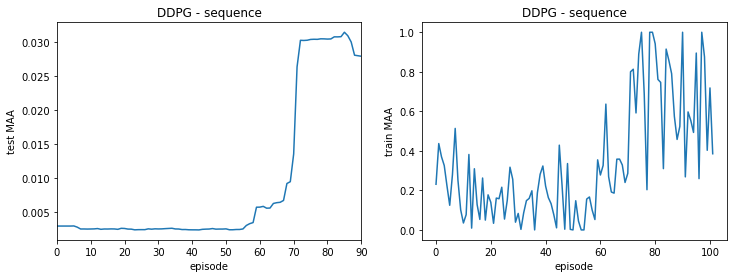

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
f,ax = plt.subplots(figsize=(12, 4), ncols=2)  

df = pd.read_csv('seq_rec.csv', header=None)
ax[0].plot(list(range(len(df))),df[0])
ax[1].plot(list(range(len(df))),df[1])

    

ax[0].set_title('DDPG - sequence')
ax[1].set_title('DDPG - sequence')
ax[0].set_xlim(0,90)

ax[0].set_xlabel('episode')
ax[0].set_ylabel('test MAA')
ax[1].set_xlabel('episode')
ax[1].set_ylabel('train MAA')


In [41]:
#random sequence baseline
p = 1/103000
A=np.array([p]*10)
L=np.array([p]*10)
T=10
MAA = np.sum(A*L)/T
print(MAA)

9.425959091337543e-11
